## CLASSIGY NEW DATA


In [1]:
import glob
import logging
from pathlib import Path

import arviz as az
import joblib
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_dic_data,
    get_image,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    compute_posterior_assignments,
    plot_1d_velocity_clustering,
)
from ppcluster.preprocessing import (
    apply_dic_filters,
    preproc_features,
)
from ppcluster.roi import PolygonROISelector

%matplotlib widget

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [2]:
date = "2024-08-28"
camera_name = "PPCX_Tele"
output_dir = Path("output") / f"{camera_name}_PyMC"

# Load posterior and scaler
PRIOR_STRENGTH = 0.4
reference_start_date = "2024-08-23"
reference_end_date = "2024-08-28"
posterior_base_name = (
    f"PPCX_mcmc_{camera_name}_pooled_{reference_start_date}_{reference_end_date}"
)
idata = az.from_netcdf(output_dir / f"{posterior_base_name}_posterior.idata.nc")
scaler = joblib.load(output_dir / f"{posterior_base_name}_scaler.joblib")

In [3]:
# Get DIC data
dic_ids = get_dic_analysis_ids(db_engine, camera_name=camera_name, reference_date=date)
if len(dic_ids) == 0:
    raise ValueError("No DIC analyses found for the given criteria")
elif len(dic_ids) > 1:
    logging.warning(
        "Multiple DIC analyses found for the given criteria. Using the first one."
    )
dic_id = dic_ids[0]

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=[dic_id])
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)
df = get_dic_data(dic_id, config=config)
df = apply_dic_filters(
    df,
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
)

selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")
logging.info(f"Data shape after filtering: {df.shape}")

2025-09-12 11:28:23 | [INFO    ] Found 1 DIC analyses matching criteria


AttributeError: 'DataFrame' object has no attribute 'tolist'

In [9]:
# Prepare new data
variables_names = config.get("clustering.variables_names")
df_features = preproc_features(df)
X = df_features[variables_names].values
X_scaled = scaler.transform(X)

# # Assign spatial priors
sector_files = sorted(glob.glob(config.get("data.sector_prior_pattern")))
sector_selectors = [PolygonROISelector.from_file(f) for f in sector_files]
prior_probs = assign_spatial_priors(df, sector_selectors, prior_strength=PRIOR_STRENGTH)

2025-09-11 19:08:48 | [INFO    ] Sector 0: 297 points with strong prior
INFO:ppcx:Sector 0: 297 points with strong prior
2025-09-11 19:08:48 | [INFO    ] Sector 1: 407 points with strong prior
INFO:ppcx:Sector 1: 407 points with strong prior
2025-09-11 19:08:48 | [INFO    ] Sector 2: 440 points with strong prior
INFO:ppcx:Sector 2: 440 points with strong prior
2025-09-11 19:08:48 | [INFO    ] Sector 3: 963 points with strong prior
INFO:ppcx:Sector 3: 963 points with strong prior


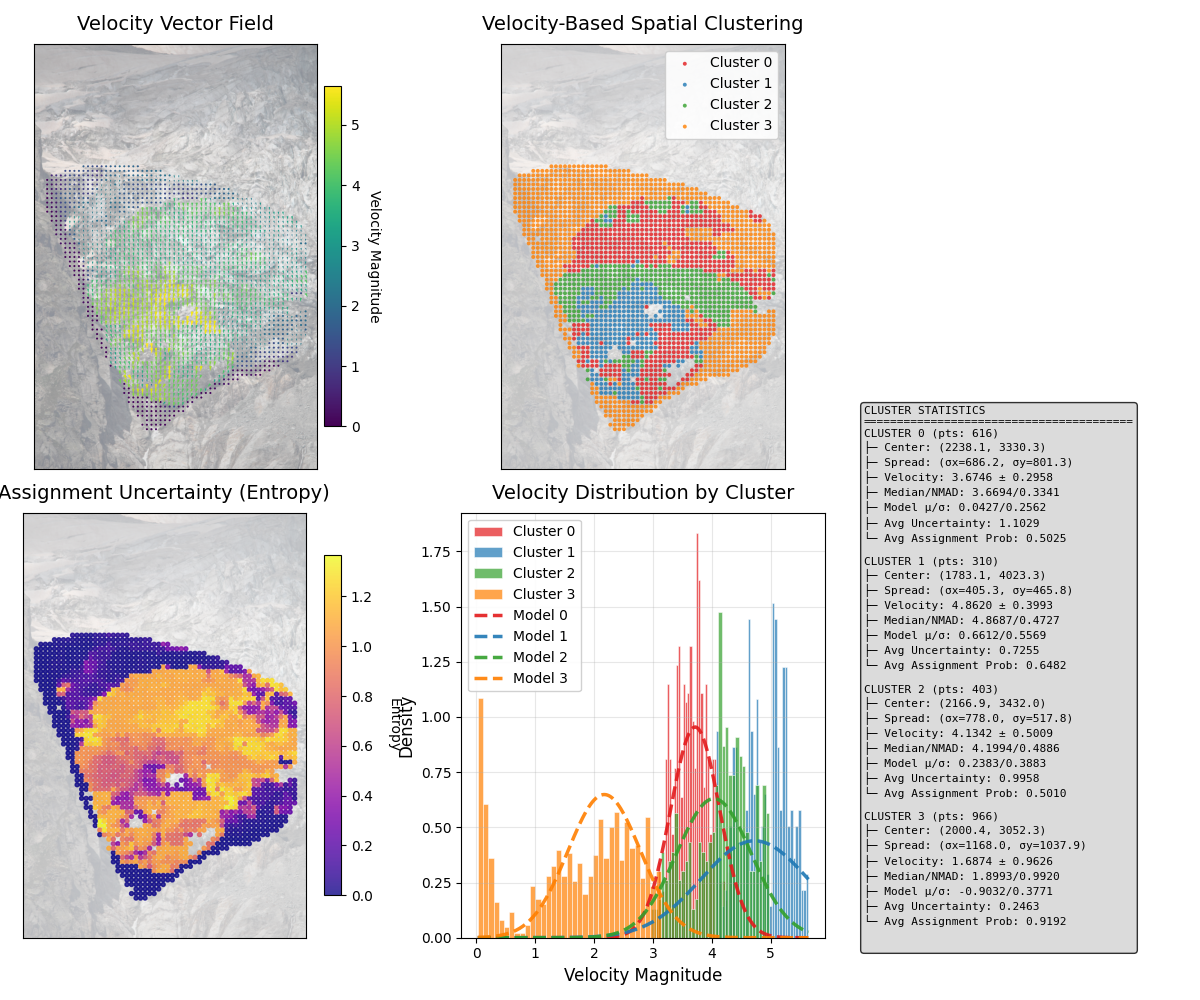

In [10]:
# compute assignments for new single-day data (fast option using posterior mean)
posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
    idata, X_scaled, prior_probs, use_posterior_mean=True
)

# Plot results
fig, uncertainty = plot_1d_velocity_clustering(
    df_features,
    img,
    idata=idata,
    cluster_pred=cluster_pred,
    posterior_probs=posterior_probs,
    scaler=scaler,
)
fig.savefig(
    output_dir / f"PPCX_mcmc_{camera_name}_{date}_dic-{dic_id}_results.png",
    dpi=300,
    bbox_inches="tight",
)